$\DeclareMathOperator*{\argmin}{argmin} $

Notes from [this excellent article](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/)

## Formalizing Decisions
The article starts, as so many math papers do, by framing the definitions. Justin introduces a number of useful notations and definitions which we will note here.

| Term | Notation | Definition |
|:----:|:--------:|:----------:|
| Decision Space | $\mathcal{A}$ | The space of all possible decisions |
| Decision | $a \in \mathcal{A}$ | A particular decision drawn from the decision space |
| Information Space | $\Theta$ | The space of all information for a particular decision |
| A piece of information | $\theta \in \Theta$ | A particular piece of information |
| Beliefs on \theta | $p(\theta)$ | The probability distribution reflecting our beliefs on the value of $\theta$ where it is uncertain | 

### Examples of Decisions
* If I am trying to decide a price to use for a cell phone, then the decision space might be the space of positive real numbers $a \in [0, + \infty )$
* If I am trying to decide between two brands of cereal, then the decision might simply be the set $\{a_1, a_2\}$

### Examples of Information
* In the cell phone case.  We might develop a model based on previous online listing in order to predict the probability the phone will be sold at a given price. In this case $\Theta \in [0, 1]$ and $\theta$ would be any particular probability for a given price. 
* For breakfast cereal we might use the grams of sugar per serving as a piece of information.  In this case we would have $\Theta \in \mathcal{R}^{2+}$, the positive quadrant of 2 dimensional real space, where $\theta_1$ and $\theta_2$ are the amounts of sugar in two selected cereals. 

### The Loss Function
At this point we know what our decisions are and we have information with which to make it.  However, we don't yet have a way of determining which decision is best, thus the loss function $\mathcal{L}$.  The crucial purpose of $\mathcal{L}$ is to quantify how good or bad a given decision $a$ is given some information $\theta$, typically as a real number.  We can thus generally think of loss/utility/acquisition functions as a mapping $$\mathcal{L}:\Theta \times \mathcal{A} \rightarrow \mathcal{R}$$

Defining a reasonable loss function is often one of the hardest parts of this problem, because it is subjective and has to capture everything that is meaningful to you. 

### Loss Function Examples
* Take the cell phone example. If my goal is to maximize my return, then I might define my loss function as having the form $\mathcal{L}(\theta, a) = -\theta a$. This loss function represents that we would like to choose a price where the probability of sale is high.  Note the negative sign is present because we want to *minimize* $\mathcal{L}$, so as $\theta$ increases $\mathcal{L}$ will become more negative. 
* In this decision between two cereals we might have a fairly simple loss function of the forms:
$$ \mathcal{L}(\theta_1, \theta_2, a) = \left\{
\begin{array}{ll}
      \theta_1 & \text{if } a = a_1 \\
      \theta_2 & \text{if } a = a_2
\end{array} 
\right.$$

### Building in Uncertainty
So in truth, we often don't have access to perfect information for a decision we would like to make.  Instead, often we are in a position where we only have some beliefs about what the value of a piece of information might be.  However, our models can handle this nicely by expressing information as probability distributions.  And where we would have typically simply minimized our loss function, now we will minimize our expectation of loss. $$\text{Expected Loss}(a) = \int_{\Theta} \mathcal{L}(\theta, a)p(\theta)d\theta$$

One could try to calculate this analytically, but we will always approach this integral computationally.  So we will draw $N$ samples $(\theta^{(1)}, ..., \theta^{(N)})$ from the distribution $p(\theta)$ to approximate the above integral as $$\text{Expected Loss}(a) \approx \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}(\theta^{(n)}, a)$$

Given the calculated expected loss, we are now in a position to choose the "best" choice.  Denoted the "bayes action", this is the choice which minmiized our expected loss.  Formally, $$\hat{a} \approx \argmin_{a \in \mathcal{A}} \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}(\theta^{(n)}, a)$$

In [4]:
import pandas as pd
import pymc3 as pm
from pymc3.math import invlogit

import bambi as bmb

In [2]:
data = pd.read_csv('cell-data.csv')
df = pd.DataFrame(data.year.unique(), columns=['year'])
df = df.reset_index()
newdata = data.merge(df, on='year', how='left').astype('float32')
newdata['year_ix'] = newdata.index.astype('float32')
newdata

,sold,scratched,year,price,index,year_ix
0,1.0,0.0,2014.0,50.0,0.0,0.0
1,1.0,0.0,2015.0,70.0,1.0,1.0
2,0.0,1.0,2010.0,40.0,2.0,2.0
3,0.0,0.0,2014.0,100.0,0.0,3.0
4,1.0,0.0,2015.0,90.0,1.0,4.0
5,1.0,0.0,2016.0,100.0,3.0,5.0


In [8]:
with pm.Model() as logit_model:
    # Linear model parameters
    beta = pm.Normal('params', 0, sd=100, shape=4)
    
    # Probability of sale
    theta = invlogit(beta[0] + newdata.price.values * beta[1] + newdata.year_ix.values * beta[2] + newdata.scratched.values * beta[3])
    
    #Likelihood
    obs_sales = pm.Binomial('obs_sales', n=newdata.shape[0], p=theta, observed=newdata.sold.values)

In [9]:
with logit_model:
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [02:29<00:00,  8.91it/s]C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\pymc3\step_methods\hmc\nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:29<00:00, 10.02it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002037E19ABE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002037E200D68>]], dtype=object)

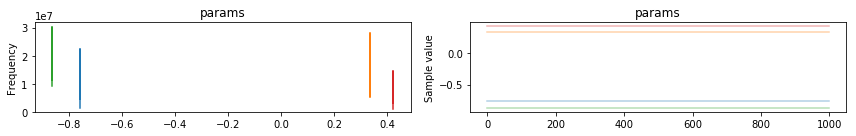

In [11]:
%matplotlib inline
pm.traceplot(trace)

In [84]:
cell_model = bmb.Model(newdata)
model_fitted = cell_model.fit('sold ~ price + scratched',
                             family='bernoulli', samples=1000, init=None)

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\bambi\models.py:273: UserWarning: Current Bayesian model has not been built yet with the None back-end; building it first before sampling begins.
  "sampling begins." % self._backend_name)
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\bambi\models.py:219: UserWarning: Modeling the probability that sold=='1.0'
  self.y.name, str(self.data[self.y.name].iloc[event])))
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Assigned NUTS to Intercept
Assigned NUTS to price
Assigned NUTS to scratched
100%|████████████████████████████████████████████████████████████████████████████| 1000/

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\bambi\results.py:265: UserWarning: Modeling the probability that sold=='1.0'
  str(self.model.data[self.model.y.name][event])))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000180EBCBDE48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000180ECC09470>]], dtype=object)

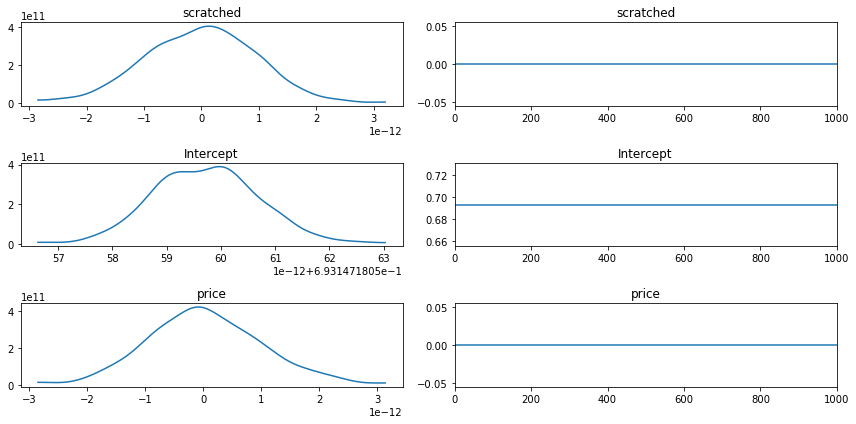

In [85]:
%matplotlib inline
model_fitted.plot()

In [86]:
model_fitted.summary()

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\bambi\results.py:346: UserWarning: Multiple MCMC chains are required in order to compute convergence diagnostics.
  warnings.warn('Multiple MCMC chains are required in order '
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\bambi\results.py:355: UserWarning: Modeling the probability that sold=='1.0'
  str(self.model.data[self.model.y.name][event])))


,mean,sd,hpd0.95_lower,hpd0.95_upper
Intercept,0.693147,1.444012e-15,0.693147,0.693147
price,0.000000,0.000000e+00,0.000000,0.000000
scratched,0.000000,0.000000e+00,0.000000,0.000000


In [87]:
model_fitted.to_df()

,Intercept,price,scratched
0,0.693147,0.0,0.0
1,0.693147,0.0,0.0
2,0.693147,0.0,0.0
3,0.693147,0.0,0.0
4,0.693147,0.0,0.0
5,0.693147,0.0,0.0
6,0.693147,0.0,0.0
7,0.693147,0.0,0.0
8,0.693147,0.0,0.0
9,0.693147,0.0,0.0
